In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
import numpy as np


In [3]:
train = pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv")
test  = pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv")


In [4]:
def build_finance(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns={
        "CustomerID": "customer_id",
        "Tenure": "tenure_months",
        "Subscription Type": "subscription_type",
        "Contract Length": "contract_length",
        "Total Spend": "total_spend",
        "Churn": "is_churned"
    }).copy()

    df["tenure_months"] = pd.to_numeric(df["tenure_months"], errors="coerce")
    df["total_spend"]   = pd.to_numeric(df["total_spend"], errors="coerce")
    df = df[df["tenure_months"] > 0]

    df["approx_monthly_revenue"] = df["total_spend"] / df["tenure_months"]
    return df

fin_train = build_finance(train)
fin_test  = build_finance(test)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [5]:
segment_rev = (
    pd.concat([fin_train, fin_test], ignore_index=True)
    .groupby(["subscription_type", "contract_length"], observed=False, as_index=False)
    .agg(
        customer_count = ("customer_id", "nunique"),
        total_mrr = ("approx_monthly_revenue", "sum"),
        avg_mrr_per_customer = ("approx_monthly_revenue", "mean"),
        churn_rate = ("is_churned", "mean")
    )
)

segment_rev["arr"] = 12 * segment_rev["total_mrr"]
segment_rev["risk_adjusted_mrr"] = segment_rev["total_mrr"] * (1 - segment_rev["churn_rate"])
segment_rev


,subscription_type,contract_length,customer_count,total_mrr,avg_mrr_per_customer,churn_rate,arr,risk_adjusted_mrr
0,Basic,Annual,63746,2.405557e+06,37.293724,0.474148,2.886669e+07,1.264966e+06
1,Basic,Monthly,35630,1.564073e+06,42.941909,0.903056,1.876888e+07,1.516279e+05
2,Basic,Quarterly,62829,2.385623e+06,37.538720,0.473478,2.862748e+07,1.256083e+06
3,Premium,Annual,66149,3.346175e+06,50.015320,0.454180,4.015410e+07,1.826409e+06
4,Premium,Monthly,35655,1.554683e+06,42.619740,0.900214,1.865619e+07,1.551359e+05
5,Premium,Quarterly,65962,3.319989e+06,49.761516,0.448290,3.983987e+07,1.831672e+06
6,Standard,Annual,66398,3.308010e+06,49.224870,0.454912,3.969612e+07,1.803156e+06
7,Standard,Monthly,35478,1.525368e+06,41.982991,0.902623,1.830442e+07,1.485358e+05
8,Standard,Quarterly,66314,3.328032e+06,49.601785,0.453491,3.993638e+07,1.818798e+06


In [7]:
num_features = ["tenure_months", "Usage Frequency", "Support Calls", "Payment Delay", "Age"]
cat_features = ["subscription_type", "contract_length", "Gender"]

X_train = fin_train[num_features + cat_features]
X_test  = fin_test[num_features + cat_features]


In [8]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


In [13]:
y_train_reg = fin_train["approx_monthly_revenue"]
y_test_reg  = fin_test["approx_monthly_revenue"]

reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

reg_model.fit(X_train, y_train_reg)
y_pred_reg = reg_model.predict(X_test)

rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
r2   = r2_score(y_test_reg, y_pred_reg)
rmse, r2


(42.033223332198624, 0.7486729322618816)

In [9]:
y_train_cls = fin_train["is_churned"].astype(int)
y_test_cls  = fin_test["is_churned"].astype(int)

cls_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

cls_model.fit(X_train, y_train_cls)
y_proba = cls_model.predict_proba(X_test)[:, 1]
y_pred  = cls_model.predict(X_test)

auc = roc_auc_score(y_test_cls, y_proba)
acc = accuracy_score(y_test_cls, y_pred)
auc, acc


(0.6383684757173544, 0.5425171653151893)

In [14]:
fin_test_scores = fin_test.copy()

fin_test_scores["expected_mrr"] = y_pred_reg
fin_test_scores["churn_prob"]   = y_proba
fin_test_scores["risk_adjusted_mrr"] = fin_test_scores["expected_mrr"] * (1 - fin_test_scores["churn_prob"])

segment_risk = (
    fin_test_scores
    .groupby(["subscription_type", "contract_length"], observed=False, as_index=False)
    .agg(
        total_expected_mrr = ("expected_mrr", "sum"),
        total_risk_adj_mrr = ("risk_adjusted_mrr", "sum"),
        avg_churn_prob     = ("churn_prob", "mean")
    )
)

segment_risk


,subscription_type,contract_length,total_expected_mrr,total_risk_adj_mrr,avg_churn_prob
0,Basic,Annual,281152.586087,21509.642395,0.904954
1,Basic,Monthly,303869.888961,8.021796,0.999978
2,Basic,Quarterly,284868.391062,22552.715090,0.899360
3,Premium,Annual,286994.061247,49372.739734,0.883252
4,Premium,Monthly,284256.079022,9.570237,0.999976
5,Premium,Quarterly,284187.150171,45619.589022,0.885292
6,Standard,Annual,304125.345325,47646.948346,0.887795
7,Standard,Monthly,290734.711927,10.210967,0.999982
8,Standard,Quarterly,278408.025205,40079.586595,0.887134


In [16]:
segment_risk = (
    fin_test_scores
    .groupby(["subscription_type", "contract_length"], observed=False, as_index=False)
    .agg(
        total_expected_mrr = ("expected_mrr", "sum"),
        total_risk_adj_mrr = ("risk_adjusted_mrr", "sum"),
        avg_churn_prob     = ("churn_prob", "mean")
    )
)


In [17]:
segment_risk["risk_gap"] = (
    segment_risk["total_expected_mrr"] - segment_risk["total_risk_adj_mrr"]
)


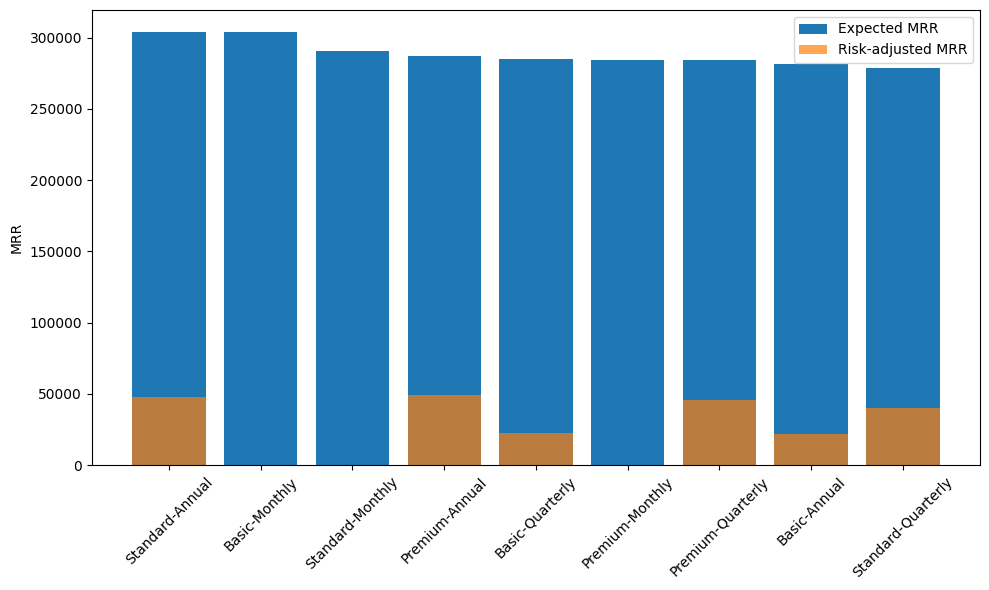

In [18]:
import matplotlib.pyplot as plt

segment_risk_sorted = segment_risk.sort_values("total_expected_mrr", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(segment_risk_sorted["subscription_type"] + "-" + segment_risk_sorted["contract_length"],
        segment_risk_sorted["total_expected_mrr"], label="Expected MRR")
plt.bar(segment_risk_sorted["subscription_type"] + "-" + segment_risk_sorted["contract_length"],
        segment_risk_sorted["total_risk_adj_mrr"], label="Risk-adjusted MRR", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("MRR")
plt.legend()
plt.tight_layout()
plt.show()


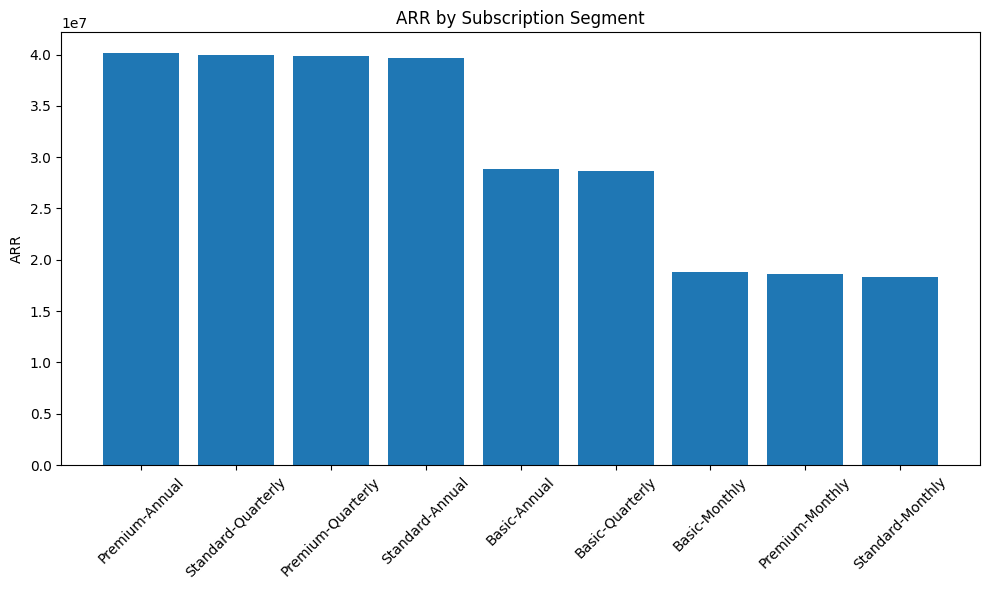

In [19]:
import matplotlib.pyplot as plt

seg_plot = segment_rev.sort_values("arr", ascending=False).copy()
seg_plot["segment"] = seg_plot["subscription_type"] + "-" + seg_plot["contract_length"]

plt.figure(figsize=(10,6))
plt.bar(seg_plot["segment"], seg_plot["arr"])
plt.xticks(rotation=45)
plt.ylabel("ARR")
plt.title("ARR by Subscription Segment")
plt.tight_layout()
plt.show()
